In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# Exploring covariance between properties across scales
**Authors**: Benjamin Jasperson, Harley T. Johnson

**GitHub URL**: https://github.com/bjasperson/property-covariance-demo

# Download Data
To begin, we need to import our project data.
Collecting this data ....

The data we will use is originally from (this manuscript)[https://arxiv.org/abs/2411.16770].

Download the CSV file and look at the first five rows.

In [2]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/data.csv?raw=true"
df_data = pd.read_csv(url_link)
df_data.head()

,Unnamed: 0,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,...,unrelaxed_formation_potential_energy_fcc,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff
0,0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,...,1.058020,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668
1,1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,...,1.058020,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794
2,2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,...,1.383830,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561
3,3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,...,0.841906,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840
4,4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,...,0.746775,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295


# Data review
It is important to get a feel for the data that you are working with. 

**Task**: explore different combinations of pairplots for the data. 

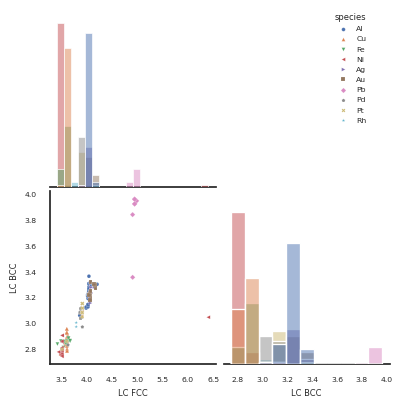

In [7]:
def pairplot_fun(df, 
                 params_list,  
                 label_dict, 
                 xlims = False, 
                 height=2.0):
    """create pairplot for select indicator properties

    Args:
        df (pandas.DataFrame): dataframe of data
        params_list (list): list of parameter strings to use
        label_dict (dict): convert label keys to human readable format
        xlims (list): list of limits to use for plotting
        height (float): pairplot height
    """
    params_list.extend(['species'])
    X = df[params_list]
    X.columns = [label_dict[x] for x in X.columns.to_list()]
    sns.set_theme(style="white", font_scale = .5)
    marker_list = ['o','^','v','<','>','s','D','p','X','*','.','P']
    g = sns.pairplot(X, hue='species', corner=True, markers = marker_list[0:len(df.species.drop_duplicates())],
                     plot_kws=dict(s=7, linewidth=0.1, rasterized = True), 
                     height=height,
                     diag_kind='hist')
    sns.move_legend(g, "upper right", bbox_to_anchor = (0.85,1))

    if xlims != False:
        for i in range(len(g.axes)):
            for j in range(len(g.axes[i])):
                g.axes[i][j].set_xlim(xlims)
                g.axes[i][j].set_ylim(xlims)


def import_label_dict():
    df_label_dict = pd.read_csv("./data/label_dict.csv")
    label_dict = df_label_dict.to_dict(orient="records")[0]
    return label_dict

label_dict = import_label_dict()
plot_param_list = ["lattice_constant_fcc", "lattice_constant_bcc"]
pairplot_fun(df_data, plot_param_list, label_dict)

# Identifying indicator properties

**Task**: run K-fold cross-validation. 

# Make predictions from first-principles indicator properties

Import DFT data. 